In [1]:
%matplotlib notebook
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.interpolate import interp1d

# Load the data
Make sure the column names below match the data you are trying to load.

#### UNIT ALERT:
The code expects the model to be in units of $GeV$ and $cm^{2}$, while the $A_{eff}$ is in $TeV$ and $m^{2}$, if the units are different one should make the necessery adjustments!

In [2]:
# Setting all the column names in the data below (should be changed with a different dataset)
model_E_col='log10E_GeV'
model_flux_col='fluence_GeV'
aeff_colE='E_TeV'
aeff_colm2='A_eff'

BASEPATH = os.path.join("data", "effective_area")

corona = pd.read_csv(os.path.join(BASEPATH, 'corona.csv'),index_col=0)
jet = pd.read_csv(os.path.join(BASEPATH, 'jet_new.csv'),index_col=0)
wind = pd.read_csv(os.path.join(BASEPATH, 'wind_new.csv'),index_col=0)
Aeff_ehe = pd.read_csv(os.path.join(BASEPATH, 'Aeff_ehe_gfu.csv'),names=[aeff_colE,aeff_colm2]).apply(lambda x: np.log10(x))

<IPython.core.display.Javascript object>


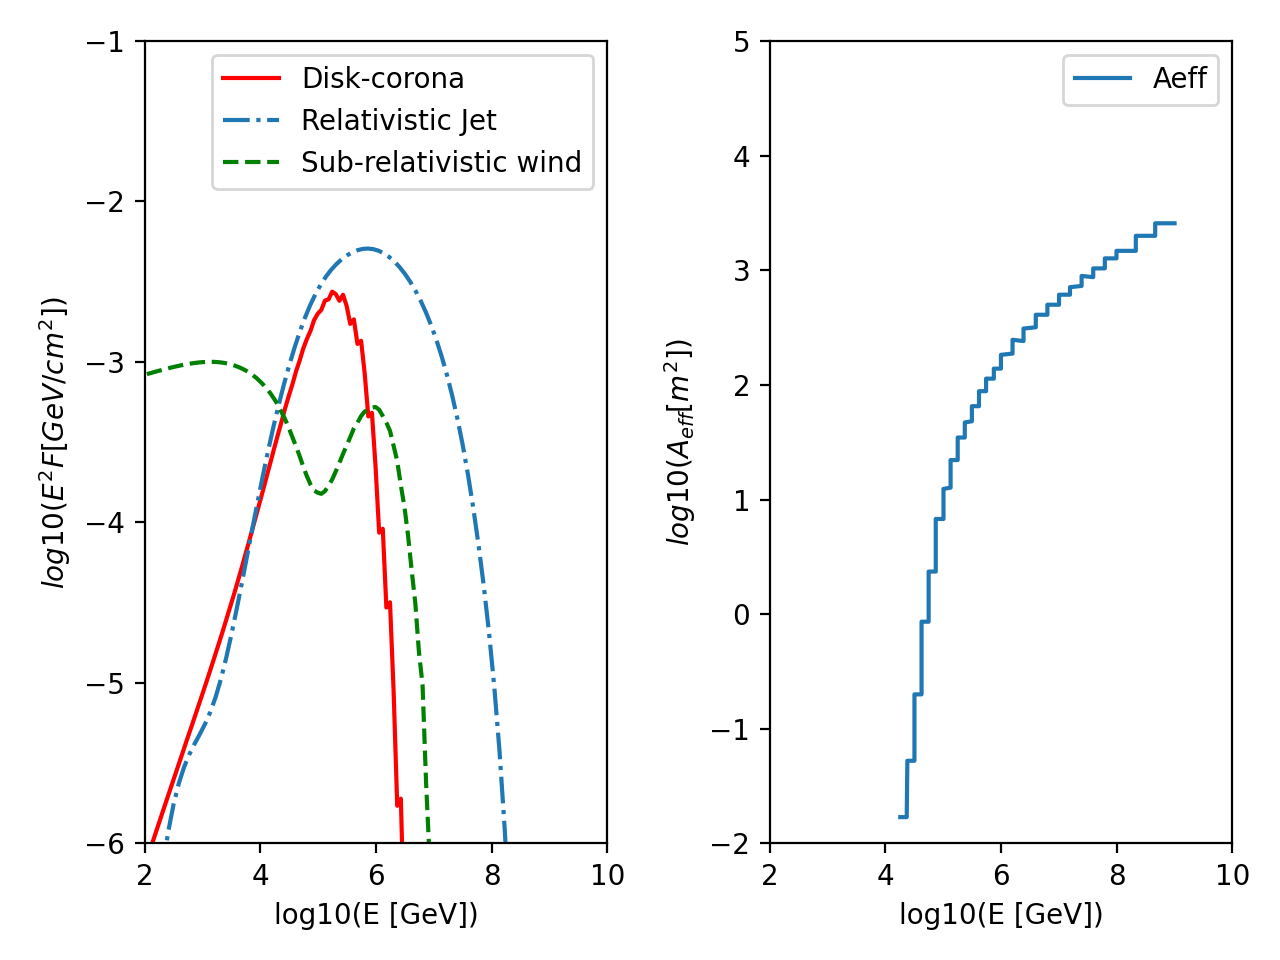

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(corona[model_E_col],corona[model_flux_col],'r',label='Disk-corona')
ax1.plot(jet[model_E_col],jet[model_flux_col],linestyle='dashdot',label='Relativistic Jet')
ax1.plot(wind[model_E_col],wind[model_flux_col],'g--',label='Sub-relativistic wind')
ax2.plot(Aeff_ehe[aeff_colE]+3,Aeff_ehe[aeff_colm2],label='Aeff')

ax1.legend()
ax2.legend()
ax1.axis([2,10,-6,-1])
ax2.axis([2,10,-2,5])
plt.show()
ax1.set_xlabel('log10(E [GeV])')
ax2.set_xlabel('log10(E [GeV])')
ax1.set_ylabel('$log10(E^{2}F [GeV/cm^{2}])$')
ax2.set_ylabel('$log10(A_{eff} [m^{2}])$')
plt.tight_layout()
plt.savefig('figure.jpg')

# Calculate $F_{\nu}$
#### UNIT ALERT:
The calculation switches units from area in $cm^{2}$ to $m^{2}$ this is the (1/1e-4) factor

In [4]:
Model = jet
Model['Fmu_m-2GeV-1'] = np.log10((1/1e-4)*(10**Model[model_flux_col]/((10**Model[model_E_col])**2)))

# Interpolate the data

<IPython.core.display.Javascript object>


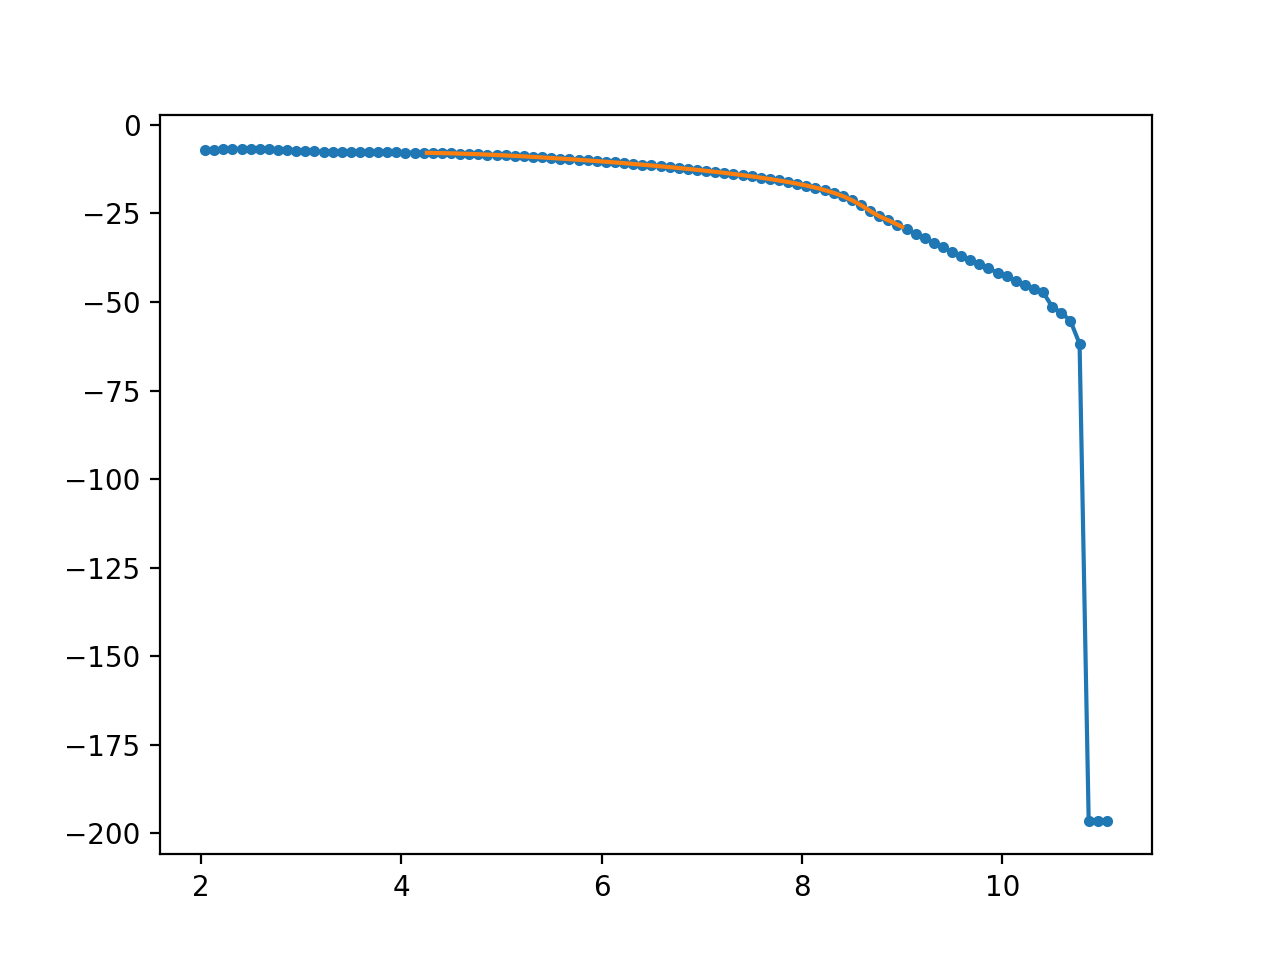

In [5]:
f = interp1d(Model[model_E_col],Model['Fmu_m-2GeV-1'])

maxpoint = np.min([np.max(Aeff_ehe[aeff_colE]+3),np.max(Model[model_E_col])])
minpoint = np.max([np.min(Aeff_ehe[aeff_colE]+3),np.min(Model[model_E_col])])
xnew = np.linspace(minpoint,maxpoint,100000)

plt.figure(5)
plt.plot(Model[model_E_col],Model['Fmu_m-2GeV-1'],marker='.')
plt.plot(xnew,f(xnew))
plt.show()

<IPython.core.display.Javascript object>


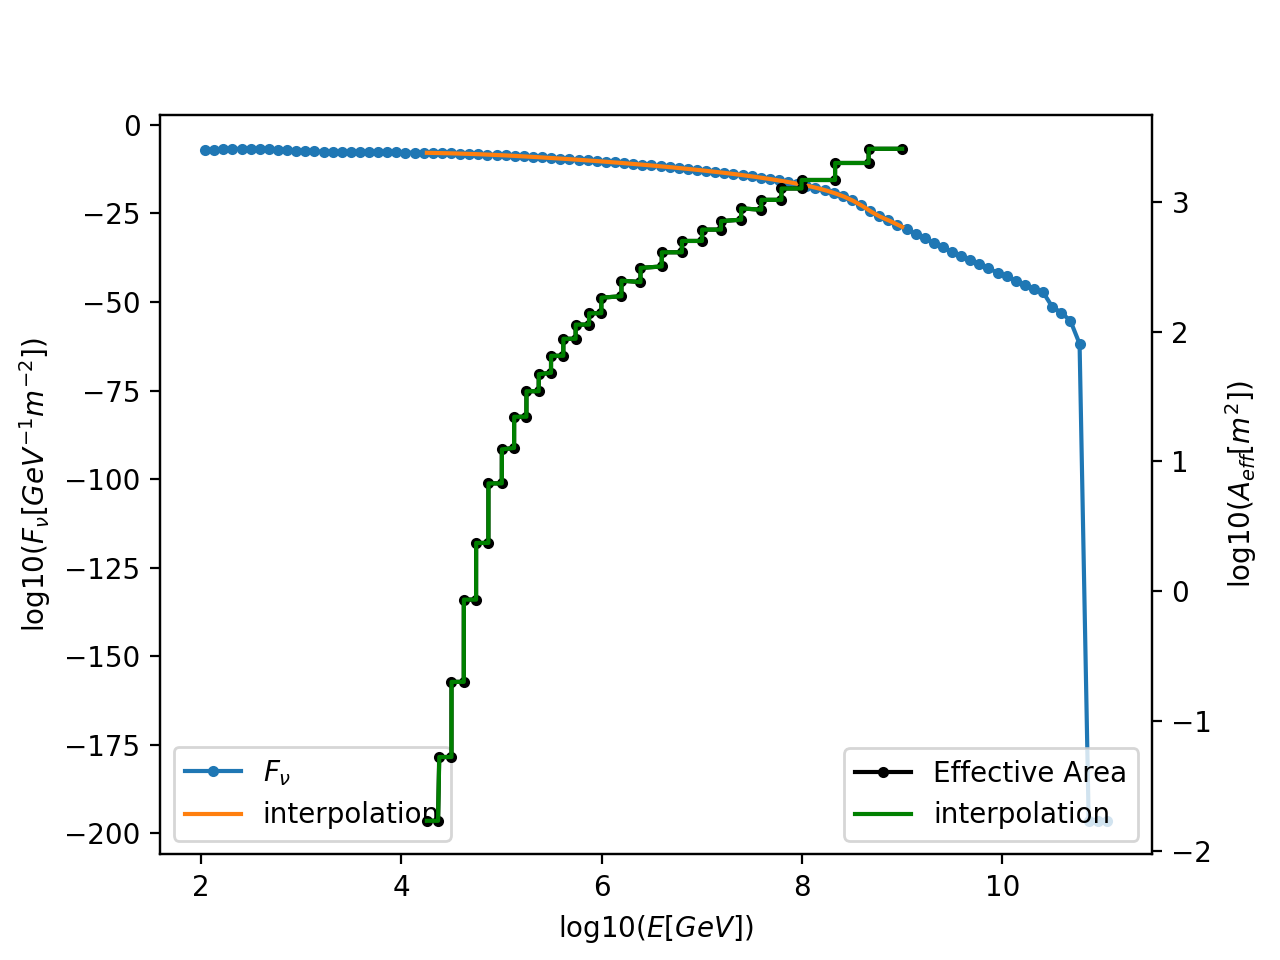

In [6]:
# Spline interpolation
tck = interpolate.splrep(Aeff_ehe[aeff_colE]+3,Aeff_ehe[aeff_colm2],s=1)
Aeff = interpolate.splev(xnew, tck)

#linear interpolation
f2 = interp1d(Aeff_ehe[aeff_colE]+3,Aeff_ehe[aeff_colm2])

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(Aeff_ehe[aeff_colE]+3,Aeff_ehe[aeff_colm2],marker='.',color='k',label='Effective Area')
ax2.plot(xnew,f2(xnew),color='green',label='interpolation')
ax1.plot(Model[model_E_col],Model['Fmu_m-2GeV-1'],marker='.',label=r'$F_{\nu}$')
ax1.plot(xnew,f(xnew),label='interpolation')
ax1.set_xlabel(r'log10($E [GeV]$)')
ax1.set_ylabel(r'log10($F_{\nu} [GeV^{-1}m^{-2}]$)')
ax2.set_ylabel(r'log10($A_{eff} [m^{2}]$)')
ax1.legend(loc='lower left',ncol=1)
ax2.legend(loc='lower right',ncol=1)
plt.show()
plt.savefig('area_vs_fnu.jpg')

# Calculate N using $\int{F_{\nu}A_{eff}dE}$

In [7]:
# Using the spline interpolation
N = np.trapz((10**f(xnew))*(10**Aeff),x=10**xnew)
print(N)
# Using the linear interpolation
N = np.trapz((10**f(xnew))*(10**f2(xnew)),x=10**xnew)
print(N)

0.027135611184952394
0.02709391731481539


# Assemble it all into a function

In [8]:
def calculate_N(Aeff,Model,model_flux_col='fluence_GeV',model_E_col='log10E_GeV',aeff_colE='E_Tev',aeff_colm2='Aeff_m2',interp_method='linear'):
    """
    A function to calculate the number of Neutrino events from a model source.
    parameters:
        Aeff - the effective area dataset in m^{2} per energy in in TeV 
        Model - the model data set in E^{2} F_{\nu} in GeV per cm^2 per energy in GeV in log10 space
        model_flux_col - the model flux column name
        model_E_col - the model energy column name
        aeff_colE - the effective area energy column name
        aeff_colm2 - the effective area area column name
        interp_method - the aeff interpolation method, by default linear, otherwise a spline
        
    Last update: 10 November 2021
    """
    
    Model['Fmu_m-2GeV-1'] = np.log10((1/1e-4)*(10**Model[model_flux_col]/((10**Model[model_E_col])**2)))
    
    f_nu_interp = interp1d(Model[model_E_col],Model['Fmu_m-2GeV-1'])
    Aeff_interp = interp1d(Aeff[aeff_colE]+3,Aeff[aeff_colm2])
    tck = interpolate.splrep(Aeff[aeff_colE]+3,Aeff[aeff_colm2],s=1)
    
    maxpoint = np.min([np.max(Aeff[aeff_colE]+3),np.max(Model[model_E_col])])
    minpoint = np.max([np.min(Aeff[aeff_colE]+3),np.min(Model[model_E_col])])
    xnew = np.linspace(minpoint,maxpoint,100000)
    Aeff_interp_spl = interpolate.splev(xnew, tck)
    if interp_method == 'linear':
        N = np.trapz((10**f_nu_interp(xnew))*(10**Aeff_interp(xnew)),x=10**xnew)
    else:
        N = np.trapz((10**f_nu_interp(xnew))*(10**Aeff_interp_spl),x=10**xnew)
    return N

In [9]:
print(calculate_N(Aeff_ehe,corona,aeff_colE='E_TeV',aeff_colm2='A_eff',interp_method='spline'),calculate_N(Aeff_ehe,jet,aeff_colE='E_TeV',aeff_colm2='A_eff',interp_method='spline'),calculate_N(Aeff_ehe,wind,aeff_colE='E_TeV',aeff_colm2='A_eff',interp_method='spline'))

0.007211096946394897 0.027135611184952394 0.0019249101616651049


/Users/simeon/.pyenv/versions/3.8.9/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
